### Predicting House Sale Prices for the City of Ames, IOWA

![RealEstate](images/home.jpg)

We'll work with housing <a href="https://doi.org/10.1080/10691898.2011.11889627">data</a> for the city of Ames, Iowa, United States from 2006 to 2010 to predict house sale prices using a machine learning linear regression model. 

First of all, we need to import pandas, matplotlib, numpy and class from scikit-learn into the environment:

In [78]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error

In [79]:
df=pd.read_csv("AmesHousing.tsv", delimiter="\t")

#### Descriptive Statistics

In [80]:
print("\033[1mNumber of houses:\033[0m", len(df))
print("\033[1mNumber of Features\033[0m", len(df.columns),"\n")
print("\033[1mFeatures(columns) Names:\n", df.columns,"\n")
print("\033[1mFirst 5 Houses:")
df.head()

Number of houses: 2930
Number of Features 82 

Features(columns) Names:
 Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
  

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [81]:
print("Number of Rows and Columns:", df.shape)

Number of Rows and Columns: (2930, 82)


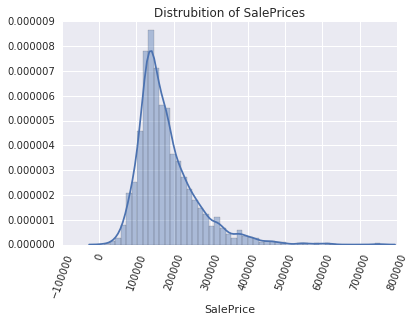

In [82]:
ax = sns.distplot(df['SalePrice'])
plt.xticks(rotation=70)
plt.title("Distrubition of SalePrices")
plt.show()

The above distribution plot for the Sale Price column is skewed to the right so the modeling may not be useful for high price houses.

#### Feature Engineering

We need to make some cleaning and wrangling of the data. Let's start by setting up a pipeline of functions that will let us quickly iterate on different models. 

![pipeline](images/pipeline.svg)

For such a pipeline, let's explore and experiment the process of preparing data and features in the next few cells. Then, by creating a transform_featurss() function that includes them, we will not damage our main data while using this function in the following processes.

##### Drop any columns with %5 or more missing values
To start with, we'll remove the columns with more than 5% of missing values. Here, the selected cut-off of 5% is tentative and can be played with in the future, to obtain a more precise model.

In [83]:
df_missing_values = df.isnull().sum()*100/len(df)
testdf=df.drop(df_missing_values[df_missing_values > 5].index, axis=1)

print("Number of remaining features:", len(testdf.columns),"\n\n")
print("The remaining features with missing values (<= 5%):\n", df_missing_values[(df_missing_values <= 5)&(df_missing_values != 0)].sort_values(ascending=False).round(2))


Number of remaining features: 71 


The remaining features with missing values (<= 5%):
 Bsmt Exposure     2.83
BsmtFin Type 2    2.76
BsmtFin Type 1    2.73
Bsmt Cond         2.73
Bsmt Qual         2.73
Mas Vnr Area      0.78
Mas Vnr Type      0.78
Bsmt Half Bath    0.07
Bsmt Full Bath    0.07
Garage Area       0.03
Garage Cars       0.03
Electrical        0.03
Total Bsmt SF     0.03
Bsmt Unf SF       0.03
BsmtFin SF 2      0.03
BsmtFin SF 1      0.03
dtype: float64


###### For numerical columns with missing values, fill in with the most common value:
After eliminate the reasonable missing values (less or equal to 5%), we should fill in the missing values using the most frequent value from the corresponding feature:

In [84]:
testdf = testdf.fillna(testdf.mode().to_dict(orient='records')[0])

###### Creating new Features

the features Yr Sold, Year Remod/Add, and Year Built are not so informative for us. If we want to use this features in linear function, we need to combine and transform features to create new ones that better capture potentially important information. 

We can use the number of years passed after each house was built and remodeled. Let's create these features:

In [85]:
testdf['years_after_built'] = testdf['Yr Sold'] - testdf['Year Built']
testdf['years_after_remod'] = testdf['Yr Sold'] - testdf['Year Remod/Add']

In such a subtraction process, it will always be useful to question the wrong values. Let's check wrong values:

In [86]:
testdf[testdf['years_after_built'] < 0]['years_after_built']
testdf[testdf['years_after_remod'] < 0]['years_after_remod']

1702   -1
2180   -2
2181   -1
Name: years_after_remod, dtype: int64

Negative values appeared, possibly due to incorrectly entered dates. We should delete three homes' entries. 

In [87]:
wrongs = testdf[(testdf['years_after_remod'] < 0)|(testdf['years_after_built'] < 0)]
testdf = testdf.drop(wrongs.index, axis=0).reset_index(drop=True)

print("Number of remaining rows:", testdf.shape[0])

Number of remaining rows: 2927


In addtion, we should drop the columns which aren't useful for machine learning or  columns leak data about the final sale.

- Order and PID aren't useful for machine learning,
- Yr Sold, Year Built and Year Remod/Add were already used for creating new columns,
- Mo Sold, Sale Type and Sale Condition leak information about the sale.

Let's remove them.

In [88]:
testdf = testdf.drop(columns=['Order', 'PID', 'Yr Sold', 'Year Built', 'Year Remod/Add', 'Mo Sold', 'Sale Type', 'Sale Condition'], axis=1)
print("Number of Remained features:", testdf.shape[1])

Number of Remained features: 65


### Creating transform_features()


Now we can get together all above job in a single function. Let's create a flexible function of "feature engineering" for input df and a cut-off value variable

In [89]:
def transform_features(df, cutoff=5): 
    missing_values = df.isnull().sum()*100/len(df)
    
    if missing_values[missing_values > cutoff].empty == False:
        df = df.drop(missing_values[missing_values > cutoff].index, axis=1)

    df = df.fillna(df.mode().to_dict(orient='records')[0])
    
    # create new features from built year and remodeling year
    if 'Yr Sold' in df:
        if 'Year Built' in df:
            df['years_after_built'] = df['Yr Sold'] - df['Year Built']
            df = df.drop(df[df['years_after_built'] < 0].index).reset_index(drop=True)
            # drop old features (year built)
            df = df.drop(['Year Built'], axis=1)
        if 'Year Remod/Add' in df:
            df['years_after_remod'] = df['Yr Sold'] - df['Year Remod/Add']
            df = df.drop(df[df['years_after_remod'] < 0].index).reset_index(drop=True)
            # drop old features (year remodeling)
            df = df.drop(['Year Remod/Add'], axis=1)
        df = df.drop(['Yr Sold'], axis=1)
    
    # drop columns not useful for ML and columns leak info about the final sale
    for feature in ['Order', 'PID', 'Mo Sold', 'Yr Sold', 'Sale Type', 'Sale Condition']:
        if feature in df:
            df = df.drop(feature, axis=1)
    return df


#### ML Modeling for pretest

We will create feature selection function and ML modeling function for rough prediction of SalePrice then we will improve these functions. Let's create these function and see the first results:

In [90]:
def select_features(df):
    return df[["Gr Liv Area", "SalePrice"]]

def train_and_test(df):
    train=df[0:1460]
    test=df[1460:]
    
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])

    features=numeric_train.columns.drop("SalePrice")
    
    lr = LinearRegression()
    lr.fit(train[features], train["SalePrice"])
    test_prediction=lr.predict(test[features])
    test_mse=mean_squared_error(test_prediction, test["SalePrice"])
    rmse=np.sqrt(test_mse)
    
    return rmse
    
transform_df = transform_features(df, 5)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

print("Our model returned this error:", rmse.round(2), "as a performance metric.")

Our model returned this error: 55275.37 as a performance metric.


Our model is working and giving us information about model performance. Further we'll use these performance values to compare accuracy of the model. Let's improve the feature selection part.

### Feature Selection

Our model contains the features that can degrade the performance of the model. We should identify the features and remove them from data for better performance. Let's look data types of features columns:

In [91]:
print(transform_df.dtypes.unique())

[dtype('int64') dtype('O') dtype('float64')]


![The Features of The Dataframe](images/featuresofdataframe.png)

We have numerical (integer and float), object(text) data in columns. Some of them are categorical. Categoricals are a pandas data type corresponding to categorical variables in statistics. A categorical variable takes on a limited, and usually fixed, number of possible values. Examples are gender, social class, blood type, country affiliation, observation time or rating via Likert scales etc.

It's time to move on to feature selection for numerical features.

In [92]:
numeric_features = transform_df.select_dtypes(include=['number'])
text_features = transform_df.select_dtypes(exclude='number')
print("Numeric features number:", numeric_features.shape[1])
print("Object features number:", text_features.shape[1])
print("\nNumeric features:\n", numeric_features.columns)
print("\nObject features):\n", text_features.columns)

Numeric features number: 33
Object features number: 32

Numeric features:
 Index(['MS SubClass', 'Lot Area', 'Overall Qual', 'Overall Cond',
       'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF',
       'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Garage Cars', 'Garage Area', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
       'Pool Area', 'Misc Val', 'SalePrice', 'years_after_built',
       'years_after_remod'],
      dtype='object')

Object features):
 Index(['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Co

Some of them are categorical features besides they are also text features. Also There may be a categorical features (for example "MS SubClass") in numericals features. We have to look up the data documentation to select the right ones.

We should pursue a strategy that involves estimating with numerical features alone, with both numerical and categorical features together. We then need to compare the RMSE values to compare their prediction performance. 

###### a. The prediction based on Numerical Features

In [93]:
numeric_features.head(5)

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,years_after_built,years_after_remod
0,20,31770,6,5,112.0,639.0,0.0,441.0,1080.0,1656,...,210,62,0,0,0,0,0,215000,50,50
1,20,11622,5,6,0.0,468.0,144.0,270.0,882.0,896,...,140,0,0,0,120,0,0,105000,49,49
2,20,14267,6,6,108.0,923.0,0.0,406.0,1329.0,1329,...,393,36,0,0,0,0,12500,172000,52,52
3,20,11160,7,5,0.0,1065.0,0.0,1045.0,2110.0,2110,...,0,0,0,0,0,0,0,244000,42,42
4,60,13830,5,5,0.0,791.0,0.0,137.0,928.0,928,...,212,34,0,0,0,0,0,189900,13,12


##### Which features correlate strongly with our target column, SalePrice?

For this question, let's generate a correlation heatmap matrix of the numerical features in the training data set. Firstly we will look corelation between all numeric features and SalePrice.

In [94]:
numeric_features_corr = numeric_features.corr()['SalePrice'].abs().sort_values(ascending=False).drop('SalePrice')
print("\nCorelation between all numeric features and SalePrice:")
numeric_features_corr


Corelation between all numeric features and SalePrice:


Overall Qual         0.801206
Gr Liv Area          0.717596
Garage Cars          0.648361
Total Bsmt SF        0.644012
Garage Area          0.641425
1st Flr SF           0.635185
years_after_built    0.558979
Full Bath            0.546118
years_after_remod    0.534985
Mas Vnr Area         0.506983
TotRms AbvGrd        0.498574
Fireplaces           0.474831
BsmtFin SF 1         0.439284
Wood Deck SF         0.328183
Open Porch SF        0.316262
Half Bath            0.284871
Bsmt Full Bath       0.276258
2nd Flr SF           0.269601
Lot Area             0.267520
Bsmt Unf SF          0.182751
Bedroom AbvGr        0.143916
Enclosed Porch       0.128685
Kitchen AbvGr        0.119760
Screen Porch         0.112280
Overall Cond         0.101540
MS SubClass          0.085128
Pool Area            0.068438
Low Qual Fin SF      0.037629
Bsmt Half Bath       0.035875
3Ssn Porch           0.032268
Misc Val             0.019273
BsmtFin SF 2         0.006127
Name: SalePrice, dtype: float64

Let's keep only the features with a correlation coefficient higher or equal to 0.4. Again, this cut-off is tentative and can be reconsidered for the sake of testing different models.

In [95]:
numeric_features_affects_sp = numeric_features.drop(numeric_features_corr[numeric_features_corr < 0.4].index, axis=1)
print("Number of remaining numeric features:", numeric_features_affects_sp.shape[1])

Number of remaining numeric features: 14


The Numerical features with a correlation coefficient equal or higher to 0.4 with SalePrice:

In [96]:
print("numeric_features:", numeric_features_affects_sp.columns.values)

numeric_features: ['Overall Qual' 'Mas Vnr Area' 'BsmtFin SF 1' 'Total Bsmt SF' '1st Flr SF'
 'Gr Liv Area' 'Full Bath' 'TotRms AbvGrd' 'Fireplaces' 'Garage Cars'
 'Garage Area' 'SalePrice' 'years_after_built' 'years_after_remod']


These numerical features most affects SalePrice based on our cut-off.

In [97]:
numeric_features_affects_sp.corr()['SalePrice'].abs().sort_values(ascending=False)

SalePrice            1.000000
Overall Qual         0.801206
Gr Liv Area          0.717596
Garage Cars          0.648361
Total Bsmt SF        0.644012
Garage Area          0.641425
1st Flr SF           0.635185
years_after_built    0.558979
Full Bath            0.546118
years_after_remod    0.534985
Mas Vnr Area         0.506983
TotRms AbvGrd        0.498574
Fireplaces           0.474831
BsmtFin SF 1         0.439284
Name: SalePrice, dtype: float64

Some of them may alredy correlate to each other. We should eliminate this colliniearty. Now, let's look correlation between them. 

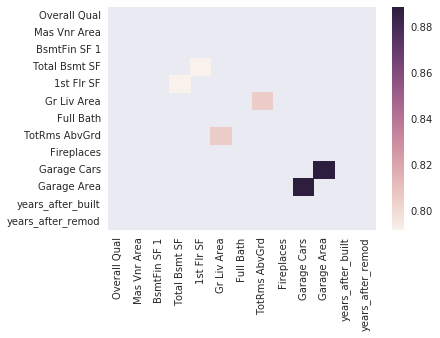

In [98]:
collinearity = numeric_features_affects_sp.corr().abs().drop('SalePrice').drop('SalePrice', axis=1)
collinearity_higher_07 = collinearity[(collinearity > 0.7) & (collinearity < 1)]

sns.heatmap(collinearity_higher_07)

We have 3 pairs of highly correlated features to each other. Let's display them in a more digestible form:

In [99]:
corr_matrix = numeric_features_affects_sp.corr().abs().drop('SalePrice').drop('SalePrice', axis=1)
all_pairs = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                       .stack()
                       .sort_values(ascending=False))
collinear_pairs = all_pairs[all_pairs > 0.7].to_frame().reset_index()
collinear_pairs.columns = ['Feature_1', 'Feature_2', 'Coeff']
collinear_pairs

,Feature_1,Feature_2,Coeff
0,Garage Cars,Garage Area,0.888866
1,Gr Liv Area,TotRms AbvGrd,0.806092
2,Total Bsmt SF,1st Flr SF,0.792227


From the plot and the table above, it seems that the following pairs of columns are strongly correlated:

- Gr Liv Area and TotRms AbvGrd
- Garage Area and Garage Cars

Looking at the data documentation, I can tell that each pair of columns reflects very similar information. Because Gr Liv Area and Garage Area are continuous variables that capture more nuance, let's drop the TotRms AbvGrd and Garage Cars.


In [100]:
numeric_features_affects_sp = numeric_features_affects_sp.drop(columns = ['TotRms AbvGrd', 'Garage Cars'])

Let's upate the numeric_features_corr variable and check the relationships of the remaining features with the sale price graphically:

Feature correlation coefficients with SalePrice
Overall Qual         0.801206
Gr Liv Area          0.717596
Total Bsmt SF        0.644012
Garage Area          0.641425
1st Flr SF           0.635185
years_after_built    0.558979
Full Bath            0.546118
years_after_remod    0.534985
Mas Vnr Area         0.506983
Fireplaces           0.474831
BsmtFin SF 1         0.439284
Name: SalePrice, dtype: float64


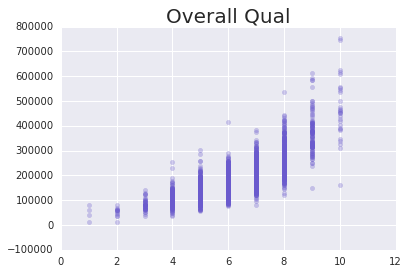

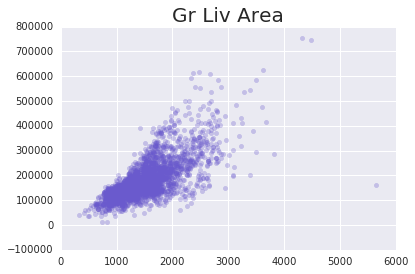

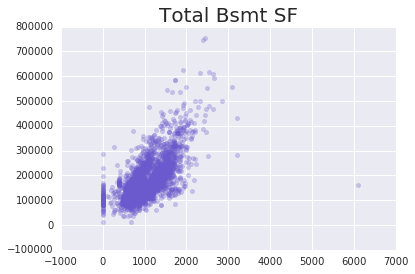

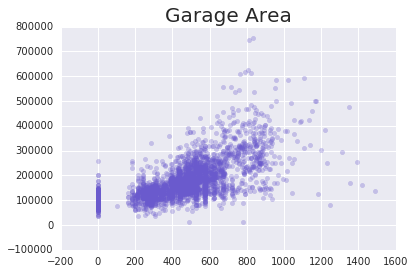

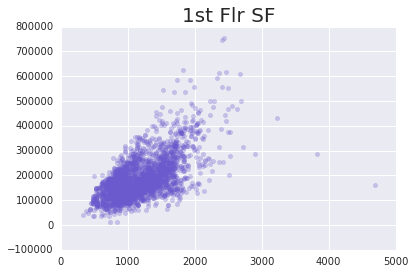

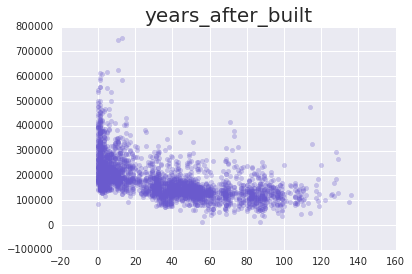

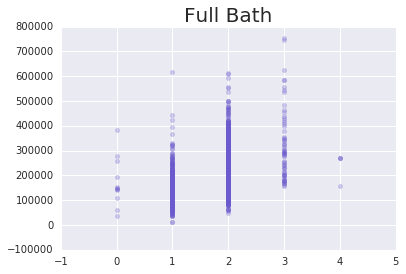

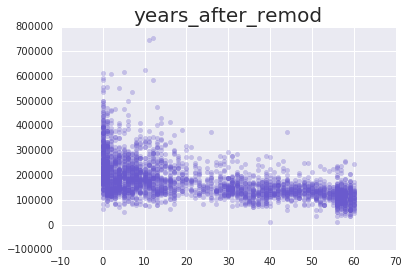

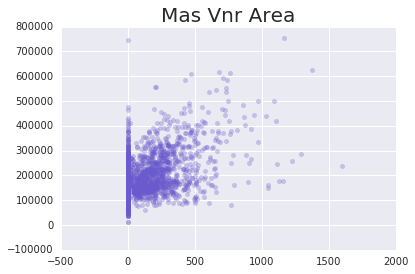

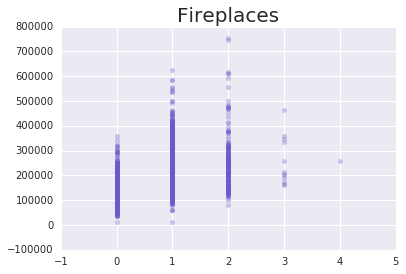

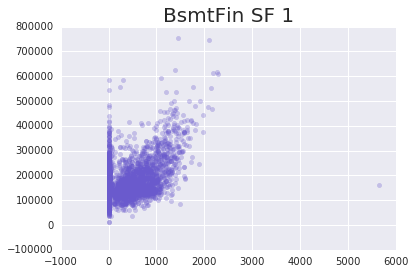

In [101]:
numeric_features_corr = numeric_features_affects_sp.corr()['SalePrice'].abs().sort_values(ascending=False).drop('SalePrice')
print("Feature correlation coefficients with SalePrice")
print(numeric_features_corr)

for feature in numeric_features_corr.index:
    if feature in numeric_features_affects_sp:
        plt.figure()
        plt.scatter(numeric_features_affects_sp[feature], numeric_features_affects_sp['SalePrice'], 
                    color='slateblue', alpha=0.3)
        plt.title(feature, fontsize=20)
        sns.despine()

Some of continuous features above have outliers. Let's remove those outliers and recalculate the number of the remaining rows. (Note: here and above (for creating the boxplots) we used the whisker coefficient value of 2, instead of the "traditional" 1.5. We selected such a conservative value by using a trial-and-error approach, since the lower values, given too many outliers, resulted in removing up to 18% of all the rows.)

In [102]:
print("Number of rows before removing the outliers:", numeric_features_affects_sp.shape[0])

for feature in ['Gr Liv Area', 'Total Bsmt SF', 'Mas Vnr Area', 'BsmtFin SF 1', 'Wood Deck SF', 'Open Porch SF']:
    if feature in numeric_features_affects_sp:
        Q1 = numeric_features_affects_sp[feature].quantile(0.25)
        Q3 = numeric_features_affects_sp[feature].quantile(0.75)
        IQR = Q3 - Q1
        numeric_features_affects_sp=numeric_features_affects_sp.drop(numeric_features_affects_sp[numeric_features_affects_sp[feature] > (Q3 + 2 * IQR)].index)
numeric_features_affects_sp = numeric_features_affects_sp.reset_index(drop=True)

print("Number of rows after removing the outliers:", numeric_features_affects_sp.shape[0])

Number of rows before removing the outliers: 2927
Number of rows after removing the outliers: 2765


Feature correlation coefficients with SalePrice

Overall Qual         0.801610
Gr Liv Area          0.690155
Garage Area          0.627175
Total Bsmt SF        0.618544
years_after_built    0.593869
1st Flr SF           0.593057
years_after_remod    0.557376
Full Bath            0.544202
Fireplaces           0.452900
Mas Vnr Area         0.429813
BsmtFin SF 1         0.389287
Name: SalePrice, dtype: float64


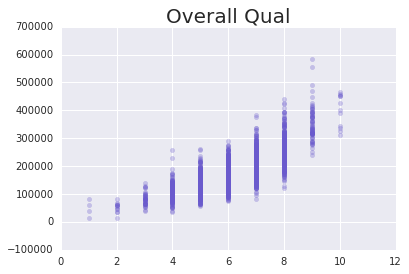

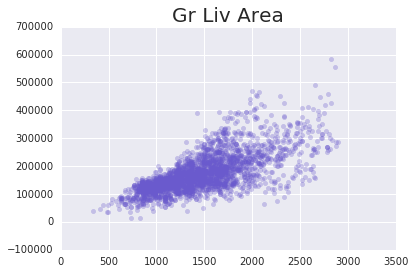

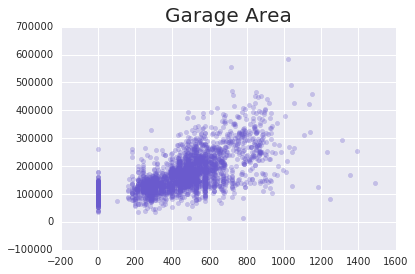

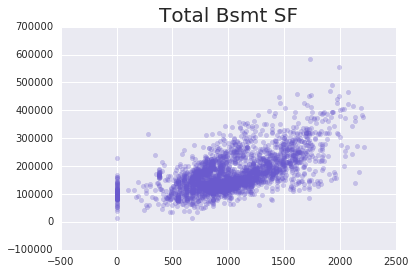

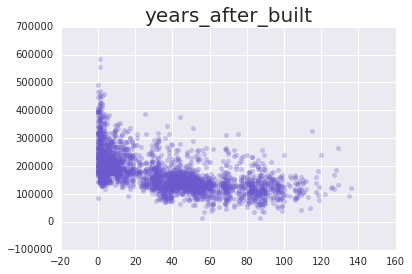

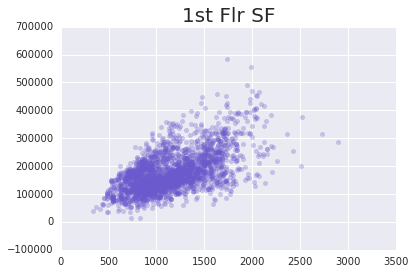

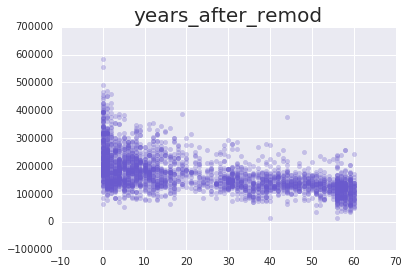

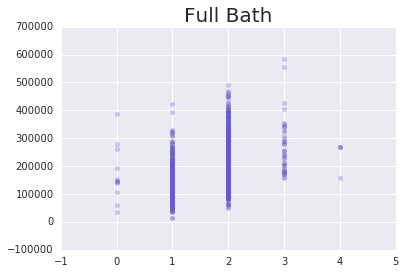

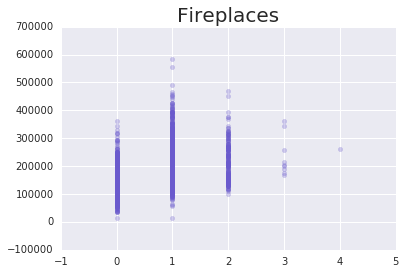

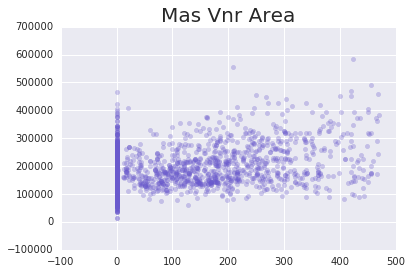

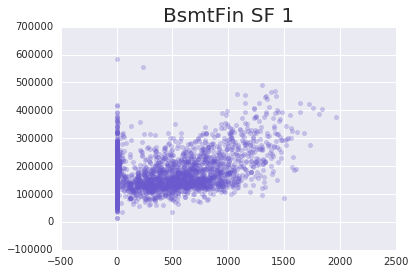

In [103]:
numeric_features_corr = numeric_features_affects_sp.corr()['SalePrice'].abs().sort_values(ascending=False).drop('SalePrice')
print("Feature correlation coefficients with SalePrice\n")
print(numeric_features_corr)

for feature in numeric_features_corr.index:
    if feature in numeric_features_affects_sp:
        plt.figure()
        plt.scatter(numeric_features_affects_sp[feature], numeric_features_affects_sp['SalePrice'], 
                    color='slateblue', alpha=0.3)
        plt.title(feature, fontsize=20)
        sns.despine()



#### b. Preparation of Categorical Features

All of the columns such as that can be categorized as nominal variables are candidates for being converted to categorical. Let's create a list of column names from documentation that are *meant* to be categorical. For this goal, we must understand each features's details of dataframe in the data documentation.

In [104]:
# Create a list of column names from documentation that are *meant* to be categorical
categorical_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

We need to make sure that these columns belong to the transformed columns  and also drop the columns with more than 10 unique values.

- Which columns are currently numerical but need to be encoded as categorical instead (because the numbers don't have any semantic meaning)?
- If a categorical column has hundreds of unique values (or categories), should we keep it? When we dummy code this column, hundreds of columns will need to be added back to the data frame.

In [105]:
#Make the list of nomial features that belongs to transform_df
transform_categoric_cols = []
for col in categorical_features:
    if col in transform_df.columns:
        transform_categoric_cols.append(col)
transform_categoric_cols

['MS SubClass',
 'MS Zoning',
 'Street',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Foundation',
 'Heating',
 'Central Air']

In [106]:
for col in transform_categoric_cols:
    if len(transform_df[col].value_counts()) > 10:
        transform_categoric_cols.remove(col)
        transform_df = transform_df.drop(columns = [col])
transform_categoric_cols


['MS Zoning',
 'Street',
 'Land Contour',
 'Lot Config',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Foundation',
 'Heating',
 'Central Air']

Let's see which categorical columns have a few unique values and more than 95% of the values in the column belong to a specific category. These columns would be similar to  low variance numerical features (no variability in the data for the model to capture).

In [107]:
#Find low variance columns
num_rows = len(transform_df)
low_variance_cols = []
for col in transform_categoric_cols:
    unique_values = transform_df[col].value_counts()
    for value in unique_values:
        if value > 0.95*num_rows:
            low_variance_cols.append(col)
            break
            
low_variance_cols

['Street', 'Condition 2', 'Roof Matl', 'Heating']

In [108]:
#Drop low variance columns
for col in low_variance_cols:
    transform_categoric_cols.remove(col)
transform_df = transform_df.drop(columns = low_variance_cols)
transform_categoric_cols

['MS Zoning',
 'Land Contour',
 'Lot Config',
 'Condition 1',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Foundation',
 'Central Air']

From the remaining categorical features, we have to exclude those that have low variability. As a threshold, let's use 95%, i.e., we'll eliminate the features where more than 95% of the values belong to a specific category. First, let's take a look at the frequency distribution of values by categorical feature, in %:

Let's select just the remaining text columns and convert to categorical form

In [109]:
# Select just the remaining text columns and convert to categorical
text_cols = transform_df.select_dtypes(include=['object'])
for col in text_cols:
    transform_df[col] = transform_df[col].astype('category')
    
# Create dummy columns and add back to the dataframe!
transform_df = pd.concat([transform_df, pd.get_dummies(transform_df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)

So that to use categorical features in lineer regression, we have converted the categorical text features to "categoric" data form with dummy columns which contain binary value (0 and 1). 

#### Update transform_features function

In [110]:
def transform_features(df, cutoff=5):

    # drop the features that contain missing values more than %5
    missing_values = df.isnull().sum()*100/len(df)
    if missing_values[missing_values > cutoff].empty == False:
        df = df.drop(missing_values[missing_values > cutoff].index, axis=1)

    # fill missing numerical values with mode of the feature     
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_values_dict)
    
    # create new features from built year and remodeling year
    if 'Yr Sold' in df:
        if 'Year Built' in df:
            df['years_after_built'] = df['Yr Sold'] - df['Year Built']
            df = df.drop(df[df['years_after_built'] < 0].index).reset_index(drop=True)
            # drop old features (year built)
            df = df.drop(['Year Built'], axis=1)
        if 'Year Remod/Add' in df:
            df['years_after_remod'] = df['Yr Sold'] - df['Year Remod/Add']
            df = df.drop(df[df['years_after_remod'] < 0].index).reset_index(drop=True)
            # drop old features (year remodeling)
            df = df.drop(['Year Remod/Add'], axis=1)
        df = df.drop(['Yr Sold'], axis=1)
    
    # drop columns not useful for ML and columns leak info about the final sale
    for feature in ['Order', 'PID', 'Mo Sold', 'Yr Sold', 'Sale Type', 'Sale Condition']:
        if feature in df:
            df = df.drop(feature, axis=1)
    return df


##### Update select_features(), train and test () functions

Now that we cleaned the features and selected the most relevant ones, let's update the functions that we created earlier based on above preparation steps. 

In [111]:
def select_features(df):
    
    #Remove strongly correlated columns
    for col in ['TotRms AbvGrd', 'Garage Cars']:
        if col in df:
            df = df.drop(columns = [col])
    
    #List of categorical columns according to the documentation
    categorical_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

    #Make the list of categorical features that belongs to df 
    transform_categoric_cols = []
    for col in categorical_features:
        if col in df.columns:
            transform_categoric_cols.append(col)

    #Remove the columns with more than 10 unique values            
    for col in transform_categoric_cols:
        if len(df[col].value_counts()) > 10:
            transform_categoric_cols.remove(col)
            df = df.drop(columns = [col])

    #Find and drop the low variance columns
    num_rows=len(df)
    low_variance_cols = []
    for col in transform_categoric_cols:
        unique_values = df[col].value_counts()
        for value in unique_values:
            if value > 0.95*num_rows:
                low_variance_cols.append(col)
                break
    for col in low_variance_cols:
        transform_categoric_cols.remove(col)
    df = df.drop(columns = low_variance_cols)
    
    #Change the type of the transformed_cat_cols columns to category
    for col in transform_categoric_cols:
        df[col] = df[col].astype('category')

    # Create dummy columns and add back to the dataframe!
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(transform_categoric_cols, axis=1)

    return df



#### Train and Test

Let's update the train and test function that we created earlier based on above preparation steps. 

In [112]:
def train_and_test(df, k=0):
    target="SalePrice"
    features = df.select_dtypes(include=['integer', 'float']).columns
    if target in features:
        features=features.drop(target)
        
    lr = LinearRegression()
    std_rmse=0
    
    half=int(len(df)/2)
    
    if k == 0:
        train = df[:half]
        test = df[half:]
        
        #train the model
        lr.fit(train[features], train[target])
        
        #test and calculate error
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test[target], predictions)
        rmse = np.sqrt(mse)
    
    elif k == 1:
        # Randomize *all* rows (frac=1) from `df` and return
        shuffled_df = df.sample(frac=1, )
        fold_one = df[:half]
        fold_two = df[half:]
        
        # train fold_one and test on fold_two
        lr.fit(fold_one[features], fold_one[target])
        predictions_one = lr.predict(fold_two[features])        
        
        mse_one = mean_squared_error(fold_two[target], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        # train fold_two and test on fold_one
        lr.fit(fold_two[features], fold_two[target])
        predictions_two = lr.predict(fold_one[features])        
        
        mse_two = mean_squared_error(fold_one[target], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        rmse = (rmse_one + rmse_two)/2
        predictions= (predictions_one, predictions_two)

    else:
        kf = KFold(k, shuffle=True, random_state=1) 
        mses = cross_val_score(lr, df[features], df[target], scoring="neg_mean_squared_error", cv=kf)
        rmses = np.sqrt(np.absolute(mses))
        rmse = np.mean(rmses)
        std_rmse = np.std(rmses)
        predictions = cross_val_predict(lr, df[features], df[target], cv = kf)
        
    return rmse, std_rmse, predictions

#### Sale Price Predictions, error metrics and standart deviations for different k values

Let's try train and test for k=5

In [113]:
df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
df_transformed = transform_features(df)
filtered_df = select_features(df_transformed)
rmse, std_rmse, predictions = train_and_test(filtered_df, k=5)

print("rmse:", rmse)
print("std_rmse:", std_rmse)
print("predictions:", predictions)

rmse: 29764.051291147316
std_rmse: 5424.194758139956
predictions: [203985.09615995 122051.42526867 148200.07183778 ... 121519.43466183
 172680.71723947 228934.6518937 ]


Let's train and test using different k to figure out which k may have better result.

In [114]:
rmse_val=[]
stds_val=[]
for k in range(10):
    rmse, std_rmse, p = train_and_test(filtered_df, k)
    rmse_val.append(rmse) #store rmse values
    stds_val.append(std_rmse)
    print('for k= ' , k , 'RMSE:', rmse, '     STD:', std_rmse)

for k=  0 RMSE: 58486.85185734194      STD: 0
for k=  1 RMSE: 43646.54244637731      STD: 0
for k=  2 RMSE: 30436.945154650155      STD: 2070.040870168272
for k=  3 RMSE: 30156.678187649264      STD: 3433.586645944337
for k=  4 RMSE: 30077.44446099372      STD: 4570.651842501621
for k=  5 RMSE: 29764.051291147316      STD: 5424.194758139956
for k=  6 RMSE: 29621.88652951771      STD: 6226.186593338952
for k=  7 RMSE: 29734.857617703055      STD: 5917.755841845102
for k=  8 RMSE: 29686.149079219915      STD: 6317.421339607797
for k=  9 RMSE: 29580.363561454204      STD: 6696.576964281509


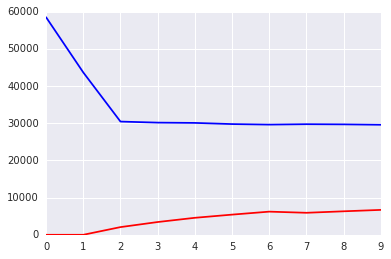

In [115]:
#plotting the rmse values against k values
rmse_curve = pd.DataFrame(rmse_val) #elbow curve 
stds_curve = pd.DataFrame(stds_val)
plt.plot(rmse_curve, color="blue")
plt.plot(stds_curve, color="red")

The RMSE values decrease after k=1. Let's examine the change from k=2. 

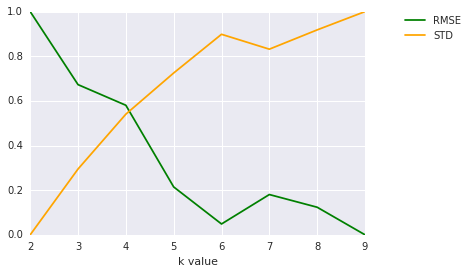

In [116]:
#Get the result of k-fold cross validation
rmses_2= rmse_val[2:]
stds_2 = stds_val[2:]
x = range(2, 10)
#RMSE
y = (rmses_2 - min(rmses_2))/(max(rmses_2) - min(rmses_2))
plt.plot(x, y, label = 'RMSE', color='green')
plt.xlabel('k value')

#STD
y = (stds_2 - min(stds_2))/(max(stds_2) - min(stds_2))
plt.plot(x,y, label = 'STD', color='orange')
plt.legend(bbox_to_anchor=(1.3,1), borderaxespad=0)



The goal is to get the lowest possible RMSE and STD which is actually a trade-off. Looking at the above plot, the best k seems to be 4.

Let's have a look at the error (the difference between predictions and the real values) graphically when k value is 4.


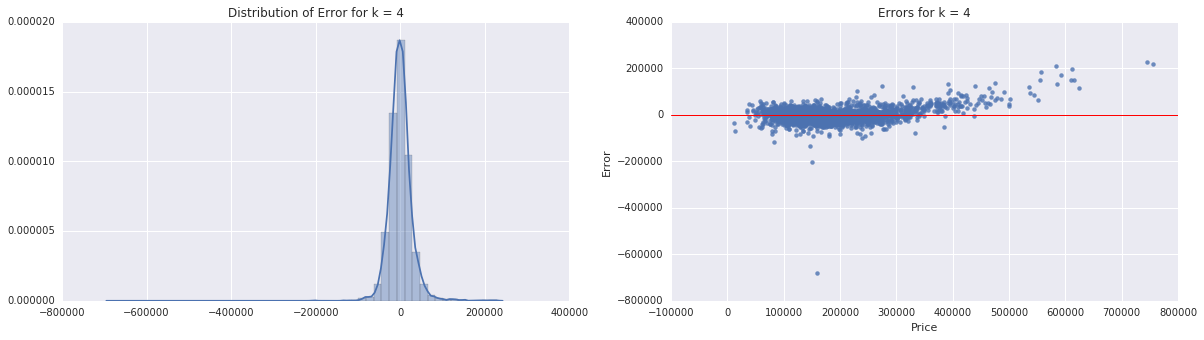

In [117]:
# Scatter plot
fig, axes = plt.subplots(ncols=2, figsize=(20,5))
x = filtered_df['SalePrice']
y = np.array(filtered_df['SalePrice']) - np.array(predictions)
yd = np.array(filtered_df['SalePrice']) - np.array(predictions) 
sns.regplot(x=x, y=y, fit_reg=False, ax = axes[1])
axes[1].axhline(linewidth=1, color='r')
axes[1].set_xlabel('Price')
axes[1].set_ylabel('Error')
axes[1].set_title('Errors for k = 4')
sns.distplot(yd, ax = axes[0])
axes[0].set_title('Distribution of Error for k = 4')
sns.despine()

The above error plots show that predictions are more accurate for the cheaper houses less than $400000. Really, In the descriptive statistics section, we had seen that the  distribution plot for the Sale Price column was skewed to the right and so we had said that the modeling may not be useful for high price houses. 

The last findings overlap with the right skewed situation in the distribution of the data. Our model is not useful for houses over 400 thousand dollars. 

#### Conclusion

In this project, we studied house prices from the city of Ames, Iowa, the USA (2006-2010) to predict house sale prices with a linear regression algorithm of machine learning. For this purpose, we created a pipeline of 3 functions to efficiently perform all the necessary manipulations and try various cut-offs and other parameters to reduce the error of predictive modeling. 

We cleaned, wrangled, and transformed the housing data. The feature engineering and feature selection techniques were used to make and select the proper features for Linear Regression Model. We accomplished to reduce the error of prediction with this way for further modeling. We applied 3 different approaches for train-test validation including holdout validation, simple cross-validation, and k-fold cross-validation. The best result has been achieved using k-fold cross validation with 4 number of folds.

The 3 main functions that we created are adapted both for the labeled data to be trained and tested and for the real unlabeled data (when available) to be predicted. The unlabeled data have to follow the structure and sequence of the features in the initial dataset used in this project. As further research, to increase the accuracy of the model, we can continue experimenting with the parameters of the functions, try other ML algorithms rather than the linear regression model, and apply some other approaches to feature engineering and selection.